https://arxiv.org/abs/1503.02531



https://github.com/kuangliu/pytorch-cifar

In [15]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [16]:


# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [17]:

# Define a simple ResNet model for the sake of this example (you can use a more complex one if needed)
# Source: https://github.com/kuangliu/pytorch-cifar
from models import ResNet18

# Create the teacher and student models
teacher = ResNet18().to(device)
student = ResNet18().to(device)

In [18]:

# Assume the teacher is pre-trained, so freeze its parameters
for param in teacher.parameters():
    param.requires_grad = False

In [19]:

# NOTE: In practice, you would train the teacher first or load its pre-trained weights.
# For the sake of this example, we'll use it without training.

# Define the KD loss function
def knowledge_distillation_loss(output, target, teacher_output, temperature, alpha):
    hard_loss = F.cross_entropy(output, target) * alpha
    soft_loss = (F.kl_div(F.log_softmax(output/temperature, dim=1),
                          F.softmax(teacher_output/temperature, dim=1),
                          reduction='batchmean') * (temperature**2) * (1. - alpha))
    return hard_loss + soft_loss


In [21]:
def calculate_accuracy(outputs, labels):
    _, predicted = outputs.max(1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [22]:
############# Plots for Losses and Accuracy #############

# Training parameters
epochs = 5
alpha = 0.9
temperature = 4.0
optimizer = optim.SGD(student.parameters(), lr=0.01, momentum=0.9)

# Lists to store metrics
losses = []
accuracies = []

# Training loop
for epoch in range(epochs):
    student.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        student_outputs = student(inputs)
        teacher_outputs = teacher(inputs)

        loss = knowledge_distillation_loss(student_outputs, labels, teacher_outputs, temperature, alpha)
        loss.backward()
        optimizer.step()

        acc = calculate_accuracy(student_outputs, labels)

        epoch_loss += loss.item()
        epoch_accuracy += acc

        if (i+1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}, Accuracy: {acc:.4f}")

    avg_epoch_loss = epoch_loss / len(train_loader)
    avg_epoch_accuracy = epoch_accuracy / len(train_loader)
    losses.append(avg_epoch_loss)
    accuracies.append(avg_epoch_accuracy)

print("Finished KD Training!")

Epoch [1/5], Step [100/782], Loss: 1.6552, Accuracy: 0.2969
Epoch [1/5], Step [200/782], Loss: 1.4479, Accuracy: 0.4844
Epoch [1/5], Step [300/782], Loss: 1.2716, Accuracy: 0.5000
Epoch [1/5], Step [400/782], Loss: 0.9492, Accuracy: 0.7344
Epoch [1/5], Step [500/782], Loss: 1.1383, Accuracy: 0.6094
Epoch [1/5], Step [600/782], Loss: 0.9342, Accuracy: 0.6406
Epoch [1/5], Step [700/782], Loss: 1.0947, Accuracy: 0.5938
Epoch [2/5], Step [100/782], Loss: 1.0479, Accuracy: 0.6094
Epoch [2/5], Step [200/782], Loss: 1.0325, Accuracy: 0.6406
Epoch [2/5], Step [300/782], Loss: 1.0685, Accuracy: 0.6875
Epoch [2/5], Step [400/782], Loss: 0.7555, Accuracy: 0.7812
Epoch [2/5], Step [500/782], Loss: 0.7189, Accuracy: 0.7500
Epoch [2/5], Step [600/782], Loss: 0.8691, Accuracy: 0.7188
Epoch [2/5], Step [700/782], Loss: 0.6619, Accuracy: 0.7969
Epoch [3/5], Step [100/782], Loss: 0.5446, Accuracy: 0.9062
Epoch [3/5], Step [200/782], Loss: 0.6158, Accuracy: 0.8438
Epoch [3/5], Step [300/782], Loss: 0.565

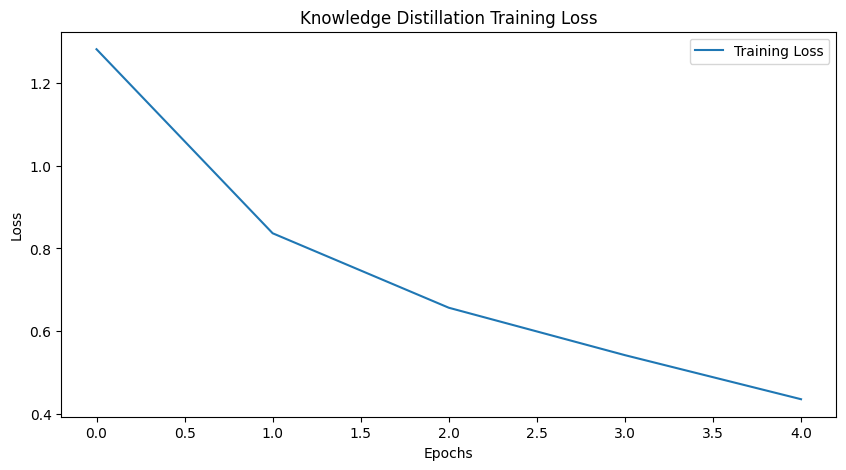

In [23]:
plt.figure(figsize=(10,5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Knowledge Distillation Training Loss')
plt.show()


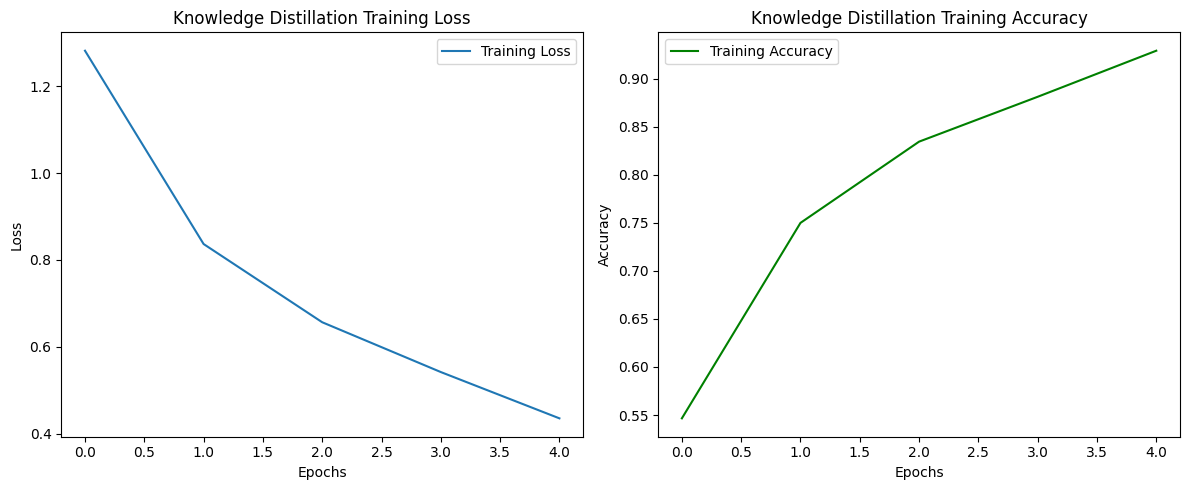

In [24]:
plt.figure(figsize=(12,5))

# Plotting loss
plt.subplot(1, 2, 1)
plt.plot(losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Knowledge Distillation Training Loss')

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Knowledge Distillation Training Accuracy')

plt.tight_layout()
plt.show()
